<a href="https://colab.research.google.com/github/bharathts1507/TSAI-Assignments-EVA4/blob/master/S6_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


In [0]:

dropout_value = 0.04
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Convolution Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_side = 28, output_size = 28, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 28, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 12, RF = 10

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 10, RF = 14
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 8, RF = 18

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6, RF = 22

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 4, RF = 26

        # OUTPUT BLOCK
        self.gap = nn.AvgPool2d(kernel_size=(4,4)) 

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1, RF = 26

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
# import torch.nn.functional as F
# dropout_value = 0.1
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         # Input Block
#         self.convblock1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(10),
#             nn.Dropout(dropout_value)
#         ) # output_size = 26, RF=3

#         # CONVOLUTION BLOCK 1
#         self.convblock2 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(20),
#             nn.Dropout(dropout_value)
#         ) # output_size = 24, RF=5

#         # TRANSITION BLOCK 1
#         self.convblock3 = nn.Sequential(
#             nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
#         ) # output_size = 24
#         self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF=5, step=2

#         # CONVOLUTION BLOCK 2
#         self.convblock4 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),            
#             nn.BatchNorm2d(20),
#             nn.Dropout(dropout_value)
#         ) # output_size = 12, RF=9, step=2
#         self.convblock5 = nn.Sequential(
#             nn.Conv2d(in_channels=20, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),            
#             nn.BatchNorm2d(32),
#             nn.Dropout(dropout_value)
#         ) # output_size = 6, RF=13, step=2
#         # self.convblock6 = nn.Sequential(
#         #     nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
#         #     nn.ReLU(),            
#         #     nn.BatchNorm2d(16),
#         #     nn.Dropout(dropout_value)
#         # ) # output_size = 6
#         # self.convblock7 = nn.Sequential(
#         #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
#         #     nn.ReLU(),            
#         #     nn.BatchNorm2d(16),
#         #     nn.Dropout(dropout_value)
#         # ) # output_size = 6
        
#         # OUTPUT BLOCK
#         self.gap = nn.Sequential(
#             nn.AvgPool2d(kernel_size=6)
#         ) # output_size = 1, RF= 23, step=2

#         self.convblock8 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
#             # nn.BatchNorm2d(10),
#             # nn.ReLU(),
#             # nn.Dropout(dropout_value)
#         ) 


#         self.dropout = nn.Dropout(dropout_value)

#     def forward(self, x):
#         x = self.convblock1(x)
#         x = self.convblock2(x)
#         x = self.convblock3(x)
#         x = self.pool1(x)
#         x = self.convblock4(x)
#         x = self.convblock5(x)
#         # x = self.convblock6(x)
#         # x = self.convblock7(x)
#         x = self.gap(x)        
#         x = self.convblock8(x)

#         x = x.view(-1, 10)
#         return F.log_softmax(x, dim=-1)

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
           Dropout-3           [-1, 10, 28, 28]               0
              ReLU-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             900
       BatchNorm2d-6           [-1, 10, 28, 28]              20
           Dropout-7           [-1, 10, 28, 28]               0
              ReLU-8           [-1, 10, 28, 28]               0
         MaxPool2d-9           [-1, 10, 14, 14]               0
           Conv2d-10           [-1, 10, 12, 12]             900
      BatchNorm2d-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
             ReLU-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1,

In [0]:
# from tqdm import tqdm

# train_losses = []
# test_losses = []
# train_acc = []
# test_acc = []

# def train(model, device, train_loader, optimizer, epoch):
#   model.train()
#   pbar = tqdm(train_loader)
#   correct = 0
#   processed = 0
#   for batch_idx, (data, target) in enumerate(pbar):
#     # get samples
#     data, target = data.to(device), target.to(device)

#     # Init
#     optimizer.zero_grad()
#     # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
#     # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

#     # Predict
#     y_pred = model(data)

#     # Calculate loss
#     loss = F.nll_loss(y_pred, target)
#     train_losses.append(loss)

#     # Backpropagation
#     loss.backward()
#     optimizer.step()

#     # Update pbar-tqdm
    
#     pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#     correct += pred.eq(target.view_as(pred)).sum().item()
#     processed += len(data)

#     # print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#     #     loss, correct, len(train_loader.dataset),
#     #     100. * correct / len(train_loader.dataset)))
    

#     pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
#     train_acc.append(100*correct/processed)

# def test(model, device, test_loader):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss /= len(test_loader.dataset)
#     test_losses.append(test_loss)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))
    
#     test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
from tqdm import tqdm

train_losses = [[],[],[],[]]
train_acc = [[],[],[],[]]
test_losses = [[],[],[],[]]
test_acc = [[],[],[],[]]

def train(model, device, train_loader, optimizer, epoch, L1_weight_decay=0, select_list=0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    # L1 loss - if required
    if L1_weight_decay:
        l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0
        for param in model.parameters():
            # https://pytorch.org/docs/stable/tensors.html#torch.Tensor.norm
            # reg_loss += param.norm(p=1) # can be viable alternative, but have to experiment
        # below is not memory efficient as it will create new vector everytime
            zero_vector = torch.rand_like(param) * 0
            reg_loss += l1_crit(param, zero_vector)        
        loss += L1_weight_decay * reg_loss  # add L1 norm regularizer 
    train_losses[select_list].append(loss)


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc[select_list].append(100*correct/processed)

def test(model, device, test_loader, select_list=0):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses[select_list].append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc[select_list].append(100. * correct / len(test_loader.dataset))

In [0]:
# summarize history for accuracy
def plot_history(lists, labels, title=None, xlabel='epochs', ylabel=None, save=False):
    '''
    Take list of sequences and their respective label and plot them
    '''
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    for vals, label in zip(lists, labels):
        plt.plot(vals, label=label)
    plt.legend(loc='best')
    if save:
        if title:
            plt.savefig(title)
            print('Fig Saved')
        else:
            print('Unable to save plot')
    plt.show()


labels = ['Without L1 or L2', 'Only L1 Reg', 'Only L2 Reg', 'Both L1 and L2']

In [0]:
def mis_classfied(model, test_loader, num=25):  
    misclassified_images = torch.rand(25,28,28) * 0
    ground_truth = torch.rand(25,1)*0
    predicted = torch.rand(25,1)*0
    num_false_images = 0

    model.eval()
    device = torch.device("cuda" if use_cuda else "cpu")

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            false_picker = torch.flatten(pred)-target
            index = 0
            for val in false_picker:
                if (val != 0):
                    misclassified_images[num_false_images] = data[index, 0, :, :]
                    ground_truth[num_false_images] = target[index]
                    predicted[num_false_images] = pred[index]
                    num_false_images = num_false_images + 1
                    if (num_false_images >= 25): 
                        break

                index = index + 1
               
            if (num_false_images >= num):
                  break
    return misclassified_images, ground_truth, predicted

In [0]:
def plot_misclassified(misclassified_images, ground_truth, predicted, title=''):
    num_img_rows = 5
    num_img_cols = 5

    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    fig.suptitle(title) #super title

    for i in range(25):
        plt.subplot(5,5,i+1)
        # plt.tight_layout()
        plt.imshow(misclassified_images[i,:,:], cmap='gray', interpolation='none')
        plt.title("Actual:{},Pred:{}".format(ground_truth[i].numpy(), predicted[i].numpy()))
        plt.xticks([])
        plt.yticks([])

In [0]:
# EPOCHS = 40
# L2_weight_decay = 0.0005

def run_epochs(EPOCHS=40, L1_weight_decay=0, L2_weight_decay=0, select_list=0):
    model =  Net().to(device)

    for epoch in range(EPOCHS):
        print("EPOCH:", epoch)
        if epoch < 10:
            print('Learning rate :',0.03)
            optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=L2_weight_decay)
        elif epoch < 25:
            print('Learning rate :',0.003)
            optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=L2_weight_decay)
        else:
            print('Learning rate :',0.0003)
            optimizer = optim.SGD(model.parameters(), lr=0.0003, momentum=0.9, weight_decay=L2_weight_decay)

        train(model, device, train_loader, optimizer, epoch, L1_weight_decay=0, select_list=select_list)  # quick fix
        test(model, device, test_loader, select_list=select_list) # quick fix
    return model

In [14]:

# No L1 or L2
model = run_epochs()

Loss=2.3505678176879883 Batch_id=0 Accuracy=9.38:   0%|          | 1/938 [00:00<01:55,  8.15it/s]

EPOCH: 0
Learning rate : 0.03


Loss=0.02517308108508587 Batch_id=937 Accuracy=93.68: 100%|██████████| 938/938 [01:33<00:00, 10.01it/s]
Loss=0.043057795614004135 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:31, 10.26it/s]


Test set: Average loss: 0.0464, Accuracy: 9842/10000 (98.42%)

EPOCH: 1
Learning rate : 0.03


Loss=0.009120987728238106 Batch_id=937 Accuracy=97.98: 100%|██████████| 938/938 [01:34<00:00,  9.92it/s]
Loss=0.03542046993970871 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:41,  9.24it/s]


Test set: Average loss: 0.0458, Accuracy: 9852/10000 (98.52%)

EPOCH: 2
Learning rate : 0.03


Loss=0.008493755012750626 Batch_id=937 Accuracy=98.24: 100%|██████████| 938/938 [01:34<00:00, 10.60it/s]
Loss=0.016490323469042778 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:34,  9.96it/s]


Test set: Average loss: 0.0329, Accuracy: 9898/10000 (98.98%)

EPOCH: 3
Learning rate : 0.03


Loss=0.02412530593574047 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [01:34<00:00,  9.94it/s]
Loss=0.073514424264431 Batch_id=1 Accuracy=98.44:   0%|          | 1/938 [00:00<01:35,  9.83it/s]   


Test set: Average loss: 0.0260, Accuracy: 9911/10000 (99.11%)

EPOCH: 4
Learning rate : 0.03


Loss=0.0026757039595395327 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [01:34<00:00,  9.92it/s]
Loss=0.003797139972448349 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:38,  9.47it/s]


Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

EPOCH: 5
Learning rate : 0.03


Loss=0.2918512225151062 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [01:35<00:00,  9.82it/s]
Loss=0.002229457488283515 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:43,  9.09it/s]


Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)

EPOCH: 6
Learning rate : 0.03


Loss=0.003140363609418273 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [01:35<00:00,  9.85it/s]
Loss=0.015866266563534737 Batch_id=1 Accuracy=100.00:   0%|          | 1/938 [00:00<01:36,  9.76it/s]


Test set: Average loss: 0.0239, Accuracy: 9922/10000 (99.22%)

EPOCH: 7
Learning rate : 0.03


Loss=0.00911177508533001 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [01:35<00:00,  9.85it/s]
Loss=0.0014125372981652617 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:37,  9.61it/s]


Test set: Average loss: 0.0205, Accuracy: 9934/10000 (99.34%)

EPOCH: 8
Learning rate : 0.03


Loss=0.0028715182561427355 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [01:34<00:00,  9.93it/s]
Loss=0.019437864422798157 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:38,  9.56it/s]


Test set: Average loss: 0.0234, Accuracy: 9930/10000 (99.30%)

EPOCH: 9
Learning rate : 0.03


Loss=0.02235347405076027 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [01:32<00:00, 10.13it/s]
Loss=0.02960946224629879 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:27, 10.72it/s]


Test set: Average loss: 0.0200, Accuracy: 9934/10000 (99.34%)

EPOCH: 10
Learning rate : 0.003


Loss=0.10256300866603851 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [01:37<00:00, 10.64it/s]
Loss=0.009310315363109112 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:30, 10.36it/s]


Test set: Average loss: 0.0163, Accuracy: 9945/10000 (99.45%)

EPOCH: 11
Learning rate : 0.003


Loss=0.013642320409417152 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [01:36<00:00,  9.75it/s]
Loss=0.0032224718015640974 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:49,  8.52it/s]


Test set: Average loss: 0.0150, Accuracy: 9947/10000 (99.47%)

EPOCH: 12
Learning rate : 0.003


Loss=0.17142514884471893 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [01:34<00:00,  9.92it/s]
Loss=0.001753029297105968 Batch_id=1 Accuracy=100.00:   0%|          | 1/938 [00:00<01:34,  9.96it/s]


Test set: Average loss: 0.0149, Accuracy: 9947/10000 (99.47%)

EPOCH: 13
Learning rate : 0.003


Loss=0.006573658902198076 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [01:33<00:00, 11.15it/s]
Loss=0.03157837316393852 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:27, 10.66it/s]


Test set: Average loss: 0.0147, Accuracy: 9948/10000 (99.48%)

EPOCH: 14
Learning rate : 0.003


Loss=0.31973502039909363 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [01:33<00:00, 10.00it/s]
Loss=0.04024681821465492 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:37,  9.57it/s]


Test set: Average loss: 0.0144, Accuracy: 9948/10000 (99.48%)

EPOCH: 15
Learning rate : 0.003


Loss=0.0033372375182807446 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [01:34<00:00, 11.10it/s]
Loss=0.0225546732544899 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:27, 10.65it/s]


Test set: Average loss: 0.0153, Accuracy: 9946/10000 (99.46%)

EPOCH: 16
Learning rate : 0.003


Loss=0.053173623979091644 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [01:36<00:00, 10.98it/s]
Loss=0.01287767756730318 Batch_id=1 Accuracy=100.00:   0%|          | 1/938 [00:00<01:35,  9.84it/s]  


Test set: Average loss: 0.0147, Accuracy: 9945/10000 (99.45%)

EPOCH: 17
Learning rate : 0.003


Loss=0.009646359831094742 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [01:33<00:00,  9.99it/s]
Loss=0.0028107864782214165 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:35,  9.82it/s]


Test set: Average loss: 0.0138, Accuracy: 9954/10000 (99.54%)

EPOCH: 18
Learning rate : 0.003


Loss=0.07154850661754608 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [01:34<00:00, 10.99it/s]
Loss=0.0015415129018947482 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:39,  9.45it/s]


Test set: Average loss: 0.0146, Accuracy: 9948/10000 (99.48%)

EPOCH: 19
Learning rate : 0.003


Loss=0.11421487480401993 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [01:34<00:00,  9.95it/s]
Loss=0.05371738225221634 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:45,  8.92it/s]


Test set: Average loss: 0.0138, Accuracy: 9951/10000 (99.51%)

EPOCH: 20
Learning rate : 0.003


Loss=0.07680206000804901 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [01:34<00:00,  9.94it/s]
Loss=0.02197420597076416 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:40,  9.35it/s]


Test set: Average loss: 0.0149, Accuracy: 9946/10000 (99.46%)

EPOCH: 21
Learning rate : 0.003


Loss=0.0024631298147141933 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [01:34<00:00, 10.78it/s]
Loss=0.0048365299589931965 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:31, 10.28it/s]


Test set: Average loss: 0.0154, Accuracy: 9947/10000 (99.47%)

EPOCH: 22
Learning rate : 0.003


Loss=0.005876655224710703 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [01:33<00:00, 10.08it/s]
Loss=0.018464509397745132 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:26, 10.88it/s]


Test set: Average loss: 0.0142, Accuracy: 9945/10000 (99.45%)

EPOCH: 23
Learning rate : 0.003


Loss=0.001449784031137824 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [01:37<00:00, 10.68it/s]
Loss=0.04383188486099243 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:33,  9.98it/s]


Test set: Average loss: 0.0141, Accuracy: 9952/10000 (99.52%)

EPOCH: 24
Learning rate : 0.003


Loss=0.015401684679090977 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [01:35<00:00,  9.82it/s]
Loss=0.016537679359316826 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:29, 10.45it/s]


Test set: Average loss: 0.0135, Accuracy: 9950/10000 (99.50%)

EPOCH: 25
Learning rate : 0.0003


Loss=0.0015518602449446917 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [01:35<00:00,  9.79it/s]
Loss=0.06440240889787674 Batch_id=0 Accuracy=95.31:   0%|          | 1/938 [00:00<01:37,  9.62it/s]


Test set: Average loss: 0.0142, Accuracy: 9945/10000 (99.45%)

EPOCH: 26
Learning rate : 0.0003


Loss=0.04015525430440903 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [01:34<00:00,  9.95it/s]
Loss=0.004789422266185284 Batch_id=1 Accuracy=99.22:   0%|          | 1/938 [00:00<01:36,  9.67it/s]


Test set: Average loss: 0.0136, Accuracy: 9953/10000 (99.53%)

EPOCH: 27
Learning rate : 0.0003


Loss=0.005802853964269161 Batch_id=937 Accuracy=99.40: 100%|██████████| 938/938 [01:35<00:00,  9.82it/s]
Loss=0.006398696452379227 Batch_id=1 Accuracy=100.00:   0%|          | 1/938 [00:00<01:34,  9.96it/s]


Test set: Average loss: 0.0135, Accuracy: 9952/10000 (99.52%)

EPOCH: 28
Learning rate : 0.0003


Loss=0.004761144984513521 Batch_id=937 Accuracy=99.37: 100%|██████████| 938/938 [01:33<00:00,  9.98it/s]
Loss=0.011272403411567211 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:41,  9.20it/s]


Test set: Average loss: 0.0134, Accuracy: 9945/10000 (99.45%)

EPOCH: 29
Learning rate : 0.0003


Loss=0.0029098214581608772 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [01:33<00:00, 10.07it/s]
Loss=0.003757225116714835 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:38,  9.48it/s]


Test set: Average loss: 0.0136, Accuracy: 9950/10000 (99.50%)

EPOCH: 30
Learning rate : 0.0003


Loss=0.005251748487353325 Batch_id=937 Accuracy=99.38: 100%|██████████| 938/938 [01:36<00:00, 10.37it/s]
Loss=0.059150949120521545 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:33,  9.97it/s]


Test set: Average loss: 0.0144, Accuracy: 9947/10000 (99.47%)

EPOCH: 31
Learning rate : 0.0003


Loss=0.000899007951375097 Batch_id=937 Accuracy=99.40: 100%|██████████| 938/938 [01:35<00:00,  9.83it/s]
Loss=0.0074062589555978775 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:41,  9.26it/s]


Test set: Average loss: 0.0133, Accuracy: 9949/10000 (99.49%)

EPOCH: 32
Learning rate : 0.0003


Loss=0.007755790837109089 Batch_id=937 Accuracy=99.37: 100%|██████████| 938/938 [01:35<00:00,  9.86it/s]
Loss=0.013353089801967144 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:28, 10.53it/s]


Test set: Average loss: 0.0134, Accuracy: 9952/10000 (99.52%)

EPOCH: 33
Learning rate : 0.0003


Loss=0.018600624054670334 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [01:35<00:00, 10.77it/s]
Loss=0.001744627021253109 Batch_id=1 Accuracy=99.22:   0%|          | 1/938 [00:00<01:35,  9.86it/s]


Test set: Average loss: 0.0134, Accuracy: 9952/10000 (99.52%)

EPOCH: 34
Learning rate : 0.0003


Loss=0.016202658414840698 Batch_id=937 Accuracy=99.40: 100%|██████████| 938/938 [01:34<00:00,  9.88it/s]
Loss=0.05885231867432594 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<02:21,  6.61it/s]


Test set: Average loss: 0.0138, Accuracy: 9948/10000 (99.48%)

EPOCH: 35
Learning rate : 0.0003


Loss=0.023323241621255875 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [01:34<00:00,  9.96it/s]
Loss=0.010982813313603401 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:36,  9.69it/s]


Test set: Average loss: 0.0134, Accuracy: 9949/10000 (99.49%)

EPOCH: 36
Learning rate : 0.0003


Loss=0.16911892592906952 Batch_id=937 Accuracy=99.44: 100%|██████████| 938/938 [01:34<00:00,  9.94it/s]
Loss=0.0015194768784567714 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:35,  9.81it/s]


Test set: Average loss: 0.0143, Accuracy: 9952/10000 (99.52%)

EPOCH: 37
Learning rate : 0.0003


Loss=0.10705944150686264 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [01:34<00:00,  9.88it/s]
Loss=0.004924635402858257 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:48,  8.60it/s]


Test set: Average loss: 0.0139, Accuracy: 9949/10000 (99.49%)

EPOCH: 38
Learning rate : 0.0003


Loss=0.0012186591047793627 Batch_id=937 Accuracy=99.37: 100%|██████████| 938/938 [01:34<00:00,  9.94it/s]
Loss=0.006604460999369621 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:37,  9.60it/s]


Test set: Average loss: 0.0134, Accuracy: 9951/10000 (99.51%)

EPOCH: 39
Learning rate : 0.0003


Loss=0.0803697481751442 Batch_id=937 Accuracy=99.38: 100%|██████████| 938/938 [01:35<00:00,  9.86it/s]



Test set: Average loss: 0.0136, Accuracy: 9949/10000 (99.49%)



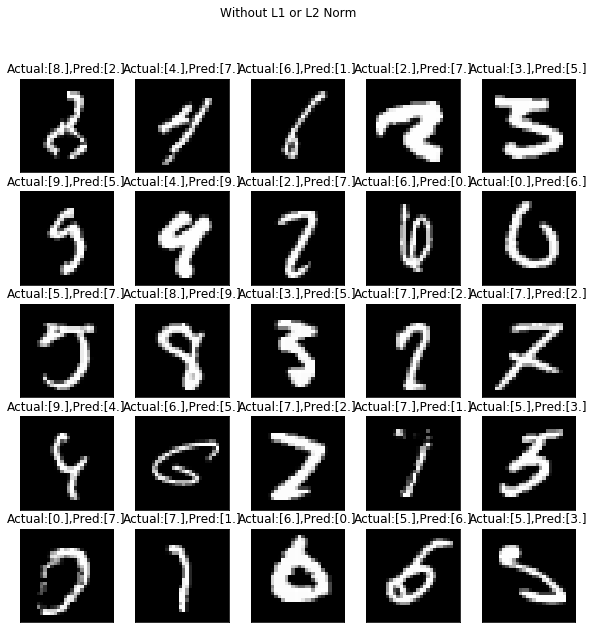

In [24]:
plot_misclassified(*mis_classfied(model, test_loader), 'Without L1 or L2 Norm')

In [25]:

# Only L1
model = run_epochs(L1_weight_decay=0.0005, select_list=1)

Loss=2.3415560722351074 Batch_id=0 Accuracy=7.81:   0%|          | 1/938 [00:00<01:52,  8.30it/s]

EPOCH: 0
Learning rate : 0.03


Loss=0.039426956325769424 Batch_id=937 Accuracy=93.00: 100%|██████████| 938/938 [01:32<00:00, 10.12it/s]
Loss=0.07476428151130676 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:36,  9.71it/s]


Test set: Average loss: 0.0537, Accuracy: 9828/10000 (98.28%)

EPOCH: 1
Learning rate : 0.03


Loss=0.036056775599718094 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [01:34<00:00,  9.91it/s]
Loss=0.03816889226436615 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:28, 10.60it/s]


Test set: Average loss: 0.0309, Accuracy: 9903/10000 (99.03%)

EPOCH: 2
Learning rate : 0.03


Loss=0.011583913117647171 Batch_id=937 Accuracy=98.21: 100%|██████████| 938/938 [01:34<00:00, 10.62it/s]
Loss=0.023040752857923508 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:40,  9.34it/s]


Test set: Average loss: 0.0274, Accuracy: 9917/10000 (99.17%)

EPOCH: 3
Learning rate : 0.03


Loss=0.0398704819381237 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [01:33<00:00, 10.00it/s]
Loss=0.11866215616464615 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:37,  9.65it/s]


Test set: Average loss: 0.0277, Accuracy: 9909/10000 (99.09%)

EPOCH: 4
Learning rate : 0.03


Loss=0.024600539356470108 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [01:36<00:00,  9.77it/s]
Loss=0.15259215235710144 Batch_id=0 Accuracy=95.31:   0%|          | 1/938 [00:00<01:47,  8.68it/s]


Test set: Average loss: 0.0256, Accuracy: 9923/10000 (99.23%)

EPOCH: 5
Learning rate : 0.03


Loss=0.001112518017180264 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [01:36<00:00,  9.68it/s]
Loss=0.015738733112812042 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:36,  9.76it/s]


Test set: Average loss: 0.0256, Accuracy: 9919/10000 (99.19%)

EPOCH: 6
Learning rate : 0.03


Loss=0.140480175614357 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [01:35<00:00,  9.83it/s]
Loss=0.0051971315406262875 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:34,  9.93it/s]


Test set: Average loss: 0.0221, Accuracy: 9926/10000 (99.26%)

EPOCH: 7
Learning rate : 0.03


Loss=0.05259128659963608 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [01:34<00:00,  9.89it/s]
Loss=0.007976623252034187 Batch_id=1 Accuracy=99.22:   0%|          | 1/938 [00:00<01:35,  9.80it/s]


Test set: Average loss: 0.0255, Accuracy: 9921/10000 (99.21%)

EPOCH: 8
Learning rate : 0.03


Loss=0.006784352008253336 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [01:35<00:00,  9.82it/s]
Loss=0.04621988534927368 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:38,  9.54it/s]


Test set: Average loss: 0.0228, Accuracy: 9926/10000 (99.26%)

EPOCH: 9
Learning rate : 0.03


Loss=0.025253815576434135 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [01:34<00:00, 10.90it/s]
Loss=0.002649433445185423 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:35,  9.82it/s]


Test set: Average loss: 0.0227, Accuracy: 9932/10000 (99.32%)

EPOCH: 10
Learning rate : 0.003


Loss=0.009618151932954788 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [01:32<00:00, 10.94it/s]
Loss=0.016411036252975464 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:26, 10.79it/s]


Test set: Average loss: 0.0184, Accuracy: 9945/10000 (99.45%)

EPOCH: 11
Learning rate : 0.003


Loss=0.008778470568358898 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [01:36<00:00,  9.70it/s]
Loss=0.0026887657586485147 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:30, 10.40it/s]


Test set: Average loss: 0.0177, Accuracy: 9941/10000 (99.41%)

EPOCH: 12
Learning rate : 0.003


Loss=0.04333919286727905 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [01:35<00:00,  9.77it/s]
Loss=0.012889588251709938 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:36,  9.71it/s]


Test set: Average loss: 0.0181, Accuracy: 9940/10000 (99.40%)

EPOCH: 13
Learning rate : 0.003


Loss=0.06224575266242027 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [01:36<00:00, 10.93it/s]
Loss=0.019284969195723534 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:30, 10.31it/s]


Test set: Average loss: 0.0165, Accuracy: 9947/10000 (99.47%)

EPOCH: 14
Learning rate : 0.003


Loss=0.0066538723185658455 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [01:36<00:00,  9.74it/s]
Loss=0.0047812508419156075 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:36,  9.74it/s]


Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.44%)

EPOCH: 15
Learning rate : 0.003


Loss=0.029514601454138756 Batch_id=937 Accuracy=99.29: 100%|██████████| 938/938 [01:34<00:00,  9.89it/s]
Loss=0.008485520258545876 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:42,  9.16it/s]


Test set: Average loss: 0.0171, Accuracy: 9943/10000 (99.43%)

EPOCH: 16
Learning rate : 0.003


Loss=0.13307005167007446 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [01:34<00:00, 11.24it/s]
Loss=0.033947672694921494 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:28, 10.53it/s]


Test set: Average loss: 0.0165, Accuracy: 9946/10000 (99.46%)

EPOCH: 17
Learning rate : 0.003


Loss=0.14407561719417572 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [01:36<00:00,  9.71it/s]
Loss=0.010272204875946045 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:41,  9.20it/s]


Test set: Average loss: 0.0169, Accuracy: 9942/10000 (99.42%)

EPOCH: 18
Learning rate : 0.003


Loss=0.003352014347910881 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [01:34<00:00,  9.97it/s]
Loss=0.0009964508935809135 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:40,  9.32it/s]


Test set: Average loss: 0.0167, Accuracy: 9946/10000 (99.46%)

EPOCH: 19
Learning rate : 0.003


Loss=0.02729402668774128 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [01:35<00:00,  9.86it/s]
Loss=0.00329010677523911 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:34,  9.95it/s]


Test set: Average loss: 0.0162, Accuracy: 9947/10000 (99.47%)

EPOCH: 20
Learning rate : 0.003


Loss=0.0042863464914262295 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [01:36<00:00,  9.76it/s]
Loss=0.017264435067772865 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:37,  9.61it/s]


Test set: Average loss: 0.0164, Accuracy: 9946/10000 (99.46%)

EPOCH: 21
Learning rate : 0.003


Loss=0.01356525719165802 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [01:35<00:00,  9.81it/s]
Loss=0.011441055685281754 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:35,  9.83it/s]


Test set: Average loss: 0.0165, Accuracy: 9944/10000 (99.44%)

EPOCH: 22
Learning rate : 0.003


Loss=0.0007877058233134449 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [01:36<00:00,  9.75it/s]
Loss=0.002474075648933649 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:39,  9.41it/s]


Test set: Average loss: 0.0168, Accuracy: 9944/10000 (99.44%)

EPOCH: 23
Learning rate : 0.003


Loss=0.00038885639514774084 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [01:36<00:00,  9.73it/s]
Loss=0.0042030224576592445 Batch_id=1 Accuracy=100.00:   0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9941/10000 (99.41%)

EPOCH: 24
Learning rate : 0.003


Loss=0.008865268900990486 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [01:34<00:00, 10.68it/s]
Loss=0.06455926597118378 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:36,  9.75it/s]


Test set: Average loss: 0.0169, Accuracy: 9944/10000 (99.44%)

EPOCH: 25
Learning rate : 0.0003


Loss=0.006924041546881199 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [01:34<00:00, 10.94it/s]
Loss=0.0032222922891378403 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:37,  9.60it/s]


Test set: Average loss: 0.0165, Accuracy: 9944/10000 (99.44%)

EPOCH: 26
Learning rate : 0.0003


Loss=0.10296858847141266 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [01:35<00:00,  9.85it/s]
Loss=0.0013662293786183 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:31, 10.18it/s]


Test set: Average loss: 0.0168, Accuracy: 9943/10000 (99.43%)

EPOCH: 27
Learning rate : 0.0003


Loss=0.021642595529556274 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [01:35<00:00, 10.90it/s]
Loss=0.06589778512716293 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:40,  9.36it/s]


Test set: Average loss: 0.0162, Accuracy: 9945/10000 (99.45%)

EPOCH: 28
Learning rate : 0.0003


Loss=0.014872285537421703 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [01:34<00:00,  9.91it/s]
Loss=0.013636340387165546 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:33, 10.00it/s]


Test set: Average loss: 0.0170, Accuracy: 9941/10000 (99.41%)

EPOCH: 29
Learning rate : 0.0003


Loss=0.003770996816456318 Batch_id=937 Accuracy=99.38: 100%|██████████| 938/938 [01:40<00:00,  9.38it/s]
Loss=0.0004775035195052624 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:40,  9.28it/s]


Test set: Average loss: 0.0163, Accuracy: 9947/10000 (99.47%)

EPOCH: 30
Learning rate : 0.0003


Loss=0.020223798230290413 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [01:36<00:00,  9.71it/s]
Loss=0.00310062849894166 Batch_id=1 Accuracy=100.00:   0%|          | 1/938 [00:00<01:35,  9.84it/s] 


Test set: Average loss: 0.0170, Accuracy: 9943/10000 (99.43%)

EPOCH: 31
Learning rate : 0.0003


Loss=0.0019032469717785716 Batch_id=937 Accuracy=99.37: 100%|██████████| 938/938 [01:36<00:00,  9.75it/s]
Loss=0.06442177295684814 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:35,  9.76it/s]


Test set: Average loss: 0.0162, Accuracy: 9944/10000 (99.44%)

EPOCH: 32
Learning rate : 0.0003


Loss=0.007483909372240305 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [01:37<00:00,  9.63it/s]
Loss=0.05939944460988045 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:36,  9.76it/s]


Test set: Average loss: 0.0158, Accuracy: 9946/10000 (99.46%)

EPOCH: 33
Learning rate : 0.0003


Loss=0.1509944200515747 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [01:36<00:00,  9.68it/s]
Loss=0.009792953729629517 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:37,  9.59it/s]


Test set: Average loss: 0.0162, Accuracy: 9944/10000 (99.44%)

EPOCH: 34
Learning rate : 0.0003


Loss=0.0006679342477582395 Batch_id=937 Accuracy=99.35: 100%|██████████| 938/938 [01:37<00:00,  9.64it/s]
Loss=0.006609445903450251 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:35,  9.77it/s]


Test set: Average loss: 0.0169, Accuracy: 9941/10000 (99.41%)

EPOCH: 35
Learning rate : 0.0003


Loss=0.010616266168653965 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [01:41<00:00,  6.08it/s]
Loss=0.011590400710701942 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:36,  9.74it/s]


Test set: Average loss: 0.0169, Accuracy: 9943/10000 (99.43%)

EPOCH: 36
Learning rate : 0.0003


Loss=0.0336325578391552 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [01:37<00:00,  9.66it/s]
Loss=0.024361224845051765 Batch_id=1 Accuracy=98.44:   0%|          | 1/938 [00:00<01:34,  9.94it/s]


Test set: Average loss: 0.0159, Accuracy: 9946/10000 (99.46%)

EPOCH: 37
Learning rate : 0.0003


Loss=0.11215043067932129 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [01:37<00:00,  9.60it/s]
Loss=0.001246863161213696 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:43,  9.07it/s]


Test set: Average loss: 0.0167, Accuracy: 9946/10000 (99.46%)

EPOCH: 38
Learning rate : 0.0003


Loss=0.03230619430541992 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [01:36<00:00,  9.68it/s]
Loss=0.042468685656785965 Batch_id=1 Accuracy=98.44:   0%|          | 1/938 [00:00<01:34,  9.90it/s]


Test set: Average loss: 0.0168, Accuracy: 9941/10000 (99.41%)

EPOCH: 39
Learning rate : 0.0003


Loss=0.0012921479064971209 Batch_id=937 Accuracy=99.38: 100%|██████████| 938/938 [01:35<00:00, 10.87it/s]



Test set: Average loss: 0.0170, Accuracy: 9943/10000 (99.43%)



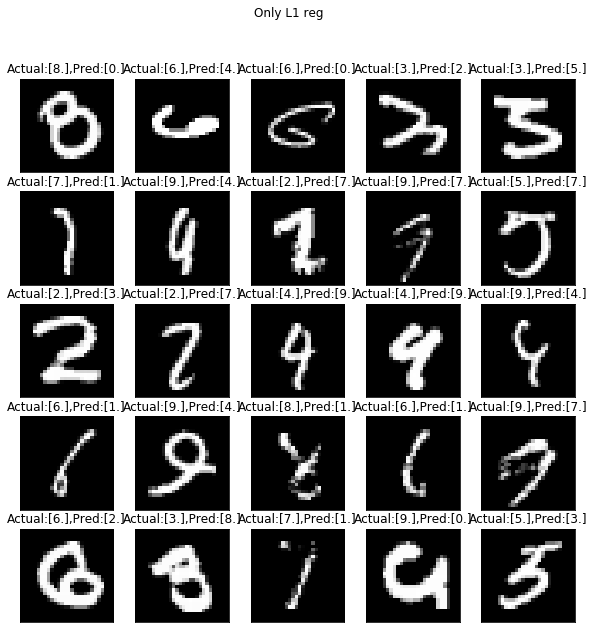

In [28]:
plot_misclassified(*mis_classfied(model, test_loader), 'Only L1 reg')

In [29]:
# Only L2
model = run_epochs(L2_weight_decay=0.0005, select_list=2)


Loss=2.3140456676483154 Batch_id=0 Accuracy=14.06:   0%|          | 1/938 [00:00<01:48,  8.60it/s]

EPOCH: 0
Learning rate : 0.03


Loss=0.07271329313516617 Batch_id=937 Accuracy=93.24: 100%|██████████| 938/938 [01:34<00:00, 10.98it/s]
Loss=0.11506863683462143 Batch_id=1 Accuracy=96.09:   0%|          | 2/938 [00:00<01:27, 10.64it/s]


Test set: Average loss: 0.0427, Accuracy: 9866/10000 (98.66%)

EPOCH: 1
Learning rate : 0.03


Loss=0.022895734757184982 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [01:32<00:00, 10.43it/s]
Loss=0.012731500901281834 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:42,  9.13it/s]


Test set: Average loss: 0.0405, Accuracy: 9877/10000 (98.77%)

EPOCH: 2
Learning rate : 0.03


Loss=0.07485467195510864 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [01:32<00:00, 10.69it/s]
Loss=0.03440496698021889 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:30, 10.33it/s]


Test set: Average loss: 0.0335, Accuracy: 9903/10000 (99.03%)

EPOCH: 3
Learning rate : 0.03


Loss=0.024225354194641113 Batch_id=937 Accuracy=98.23: 100%|██████████| 938/938 [01:33<00:00, 10.07it/s]
Loss=0.053480371832847595 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:29, 10.50it/s]


Test set: Average loss: 0.0330, Accuracy: 9891/10000 (98.91%)

EPOCH: 4
Learning rate : 0.03


Loss=0.013430961407721043 Batch_id=937 Accuracy=98.35: 100%|██████████| 938/938 [01:31<00:00, 10.24it/s]
Loss=0.122091144323349 Batch_id=1 Accuracy=96.09:   0%|          | 2/938 [00:00<01:29, 10.49it/s]


Test set: Average loss: 0.0287, Accuracy: 9929/10000 (99.29%)

EPOCH: 5
Learning rate : 0.03


Loss=0.2004948854446411 Batch_id=937 Accuracy=98.40: 100%|██████████| 938/938 [01:32<00:00, 10.15it/s]
Loss=0.08285890519618988 Batch_id=1 Accuracy=99.22:   0%|          | 1/938 [00:00<01:33,  9.99it/s] 


Test set: Average loss: 0.0333, Accuracy: 9897/10000 (98.97%)

EPOCH: 6
Learning rate : 0.03


Loss=0.021525688469409943 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [01:34<00:00,  9.95it/s]
Loss=0.014564203098416328 Batch_id=1 Accuracy=98.44:   0%|          | 1/938 [00:00<01:34,  9.96it/s]


Test set: Average loss: 0.0323, Accuracy: 9899/10000 (98.99%)

EPOCH: 7
Learning rate : 0.03


Loss=0.012447300367057323 Batch_id=937 Accuracy=98.45: 100%|██████████| 938/938 [01:35<00:00,  9.87it/s]
Loss=0.0990951880812645 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:35,  9.83it/s]


Test set: Average loss: 0.0288, Accuracy: 9911/10000 (99.11%)

EPOCH: 8
Learning rate : 0.03


Loss=0.06104840710759163 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [01:34<00:00, 10.84it/s]
Loss=0.007265515625476837 Batch_id=1 Accuracy=98.44:   0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9900/10000 (99.00%)

EPOCH: 9
Learning rate : 0.03


Loss=0.08895948529243469 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [01:31<00:00, 10.21it/s]
Loss=0.022066066041588783 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:37,  9.66it/s]


Test set: Average loss: 0.0348, Accuracy: 9898/10000 (98.98%)

EPOCH: 10
Learning rate : 0.003


Loss=0.087015300989151 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [01:29<00:00, 11.60it/s]
Loss=0.008246717974543571 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:30, 10.37it/s]


Test set: Average loss: 0.0204, Accuracy: 9942/10000 (99.42%)

EPOCH: 11
Learning rate : 0.003


Loss=0.005027769133448601 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [01:29<00:00, 10.53it/s]
Loss=0.02809196524322033 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:30, 10.38it/s]


Test set: Average loss: 0.0181, Accuracy: 9944/10000 (99.44%)

EPOCH: 12
Learning rate : 0.003


Loss=0.003467146772891283 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [01:32<00:00, 10.19it/s]
Loss=0.03692806512117386 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:26, 10.77it/s]


Test set: Average loss: 0.0190, Accuracy: 9942/10000 (99.42%)

EPOCH: 13
Learning rate : 0.003


Loss=0.05719785764813423 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [01:33<00:00, 10.02it/s]
Loss=0.003920236136764288 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:28, 10.56it/s]


Test set: Average loss: 0.0174, Accuracy: 9949/10000 (99.49%)

EPOCH: 14
Learning rate : 0.003


Loss=0.003553763497620821 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [01:33<00:00, 10.05it/s]
Loss=0.005537225399166346 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:34,  9.88it/s]


Test set: Average loss: 0.0176, Accuracy: 9950/10000 (99.50%)

EPOCH: 15
Learning rate : 0.003


Loss=0.030327986925840378 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [01:34<00:00,  9.94it/s]
Loss=0.04750814288854599 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:30, 10.32it/s]


Test set: Average loss: 0.0169, Accuracy: 9946/10000 (99.46%)

EPOCH: 16
Learning rate : 0.003


Loss=0.07955986261367798 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [01:35<00:00,  9.82it/s]
Loss=0.03285949304699898 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:35,  9.77it/s]


Test set: Average loss: 0.0175, Accuracy: 9948/10000 (99.48%)

EPOCH: 17
Learning rate : 0.003


Loss=0.014119412750005722 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [01:34<00:00, 10.37it/s]
Loss=0.0073037887923419476 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:28, 10.52it/s]


Test set: Average loss: 0.0162, Accuracy: 9951/10000 (99.51%)

EPOCH: 18
Learning rate : 0.003


Loss=0.0032788068056106567 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [01:31<00:00, 10.21it/s]
Loss=0.01349856797605753 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:29, 10.47it/s]


Test set: Average loss: 0.0167, Accuracy: 9940/10000 (99.40%)

EPOCH: 19
Learning rate : 0.003


Loss=0.0022682170383632183 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [01:35<00:00,  9.80it/s]
Loss=0.010768478736281395 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:35,  9.83it/s]


Test set: Average loss: 0.0161, Accuracy: 9953/10000 (99.53%)

EPOCH: 20
Learning rate : 0.003


Loss=0.02037196420133114 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [01:34<00:00, 10.77it/s]
Loss=0.014685260131955147 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:35,  9.85it/s]


Test set: Average loss: 0.0170, Accuracy: 9948/10000 (99.48%)

EPOCH: 21
Learning rate : 0.003


Loss=0.19728924334049225 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [01:33<00:00, 10.00it/s]
Loss=0.019316911697387695 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:39,  9.40it/s]


Test set: Average loss: 0.0168, Accuracy: 9949/10000 (99.49%)

EPOCH: 22
Learning rate : 0.003


Loss=0.01675618253648281 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [01:34<00:00,  9.96it/s]
Loss=0.01025279052555561 Batch_id=1 Accuracy=100.00:   0%|          | 1/938 [00:00<01:34,  9.96it/s] 


Test set: Average loss: 0.0169, Accuracy: 9949/10000 (99.49%)

EPOCH: 23
Learning rate : 0.003


Loss=0.011064953170716763 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [01:33<00:00, 10.05it/s]
Loss=0.006657961290329695 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:38,  9.47it/s]


Test set: Average loss: 0.0170, Accuracy: 9949/10000 (99.49%)

EPOCH: 24
Learning rate : 0.003


Loss=0.00884403195232153 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [01:33<00:00, 10.03it/s]
Loss=0.002360736019909382 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:35,  9.84it/s]


Test set: Average loss: 0.0162, Accuracy: 9953/10000 (99.53%)

EPOCH: 25
Learning rate : 0.0003


Loss=0.005177995655685663 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [01:36<00:00,  9.72it/s]
Loss=0.004458247218281031 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:27, 10.69it/s]


Test set: Average loss: 0.0166, Accuracy: 9946/10000 (99.46%)

EPOCH: 26
Learning rate : 0.0003


Loss=0.011903888545930386 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [01:34<00:00,  9.88it/s]
Loss=0.03249488025903702 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:42,  9.11it/s]


Test set: Average loss: 0.0163, Accuracy: 9946/10000 (99.46%)

EPOCH: 27
Learning rate : 0.0003


Loss=0.005833422765135765 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [01:34<00:00, 10.76it/s]
Loss=0.06032376363873482 Batch_id=0 Accuracy=95.31:   0%|          | 1/938 [00:00<01:35,  9.78it/s]


Test set: Average loss: 0.0164, Accuracy: 9948/10000 (99.48%)

EPOCH: 28
Learning rate : 0.0003


Loss=0.03262624144554138 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [01:33<00:00, 10.76it/s]
Loss=0.007899198681116104 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:36,  9.68it/s]


Test set: Average loss: 0.0159, Accuracy: 9945/10000 (99.45%)

EPOCH: 29
Learning rate : 0.0003


Loss=0.004846307449042797 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [01:34<00:00, 10.92it/s]
Loss=0.00535727059468627 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:28, 10.56it/s]


Test set: Average loss: 0.0159, Accuracy: 9947/10000 (99.47%)

EPOCH: 30
Learning rate : 0.0003


Loss=0.10868239402770996 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [01:33<00:00, 10.00it/s]
Loss=0.0022798373829573393 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:38,  9.55it/s]


Test set: Average loss: 0.0155, Accuracy: 9949/10000 (99.49%)

EPOCH: 31
Learning rate : 0.0003


Loss=0.0028843532782047987 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [01:32<00:00, 10.17it/s]
Loss=0.0033216672018170357 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:35,  9.79it/s]


Test set: Average loss: 0.0158, Accuracy: 9948/10000 (99.48%)

EPOCH: 32
Learning rate : 0.0003


Loss=0.08377304673194885 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [01:39<00:00,  9.42it/s]
Loss=0.020700542256236076 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:35,  9.85it/s]


Test set: Average loss: 0.0158, Accuracy: 9951/10000 (99.51%)

EPOCH: 33
Learning rate : 0.0003


Loss=0.03254878893494606 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [01:35<00:00,  9.78it/s]
Loss=0.011570482514798641 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:42,  9.16it/s]


Test set: Average loss: 0.0158, Accuracy: 9948/10000 (99.48%)

EPOCH: 34
Learning rate : 0.0003


Loss=0.0680367574095726 Batch_id=937 Accuracy=99.37: 100%|██████████| 938/938 [01:34<00:00, 10.91it/s]
Loss=0.07564844936132431 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:38,  9.47it/s]


Test set: Average loss: 0.0159, Accuracy: 9946/10000 (99.46%)

EPOCH: 35
Learning rate : 0.0003


Loss=0.017353802919387817 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [01:33<00:00, 10.02it/s]
Loss=0.04383452609181404 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:30, 10.33it/s]


Test set: Average loss: 0.0158, Accuracy: 9948/10000 (99.48%)

EPOCH: 36
Learning rate : 0.0003


Loss=0.06111831218004227 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [01:34<00:00,  9.94it/s]
Loss=0.0395473837852478 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:31, 10.24it/s]


Test set: Average loss: 0.0159, Accuracy: 9949/10000 (99.49%)

EPOCH: 37
Learning rate : 0.0003


Loss=0.12884521484375 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [01:34<00:00, 10.85it/s]
Loss=0.029546627774834633 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:31, 10.27it/s]


Test set: Average loss: 0.0153, Accuracy: 9949/10000 (99.49%)

EPOCH: 38
Learning rate : 0.0003


Loss=0.00984012521803379 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [01:39<00:00,  9.44it/s]
Loss=0.02989974059164524 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:37,  9.61it/s]


Test set: Average loss: 0.0161, Accuracy: 9950/10000 (99.50%)

EPOCH: 39
Learning rate : 0.0003


Loss=0.019397441297769547 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [01:34<00:00,  9.98it/s]



Test set: Average loss: 0.0161, Accuracy: 9947/10000 (99.47%)



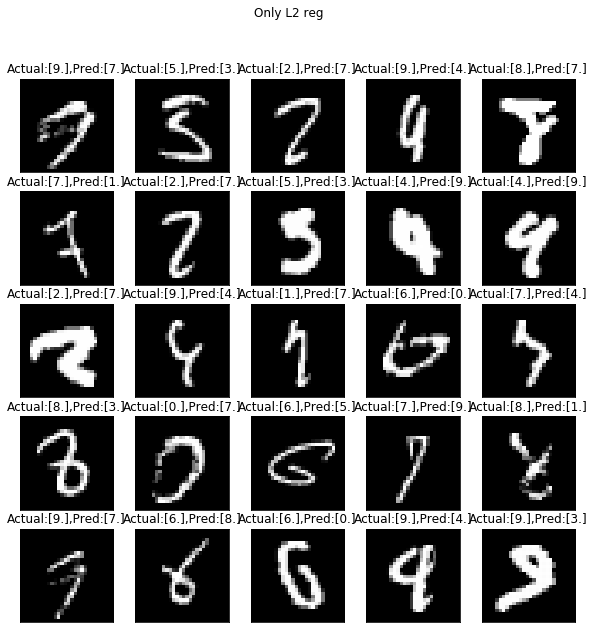

In [30]:
plot_misclassified(*mis_classfied(model, test_loader), 'Only L2 reg')

In [0]:

# Both L2 and L1
model = run_epochs(L1_weight_decay=0.0005, L2_weight_decay=0.0005, select_list=3)
plot_misclassified(*mis_classfied(model, test_loader), 'Both L1 and L2 reg')

In [0]:
plot_history(test_losses, labels, title='Test Losses', ylabel='Loss', save=1)
plot_history(train_losses, labels, title='Train Losses', ylabel='Loss')
plot_history(test_acc, labels, title='Test Accuracy', ylabel='Accuracy')
plot_history(train_acc, labels, title='Train Accuracy', ylabel='Accuracy')

In [0]:
# from torch.optim.lr_scheduler import StepLR

# model =  Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


# EPOCHS = 40
# for epoch in range(EPOCHS):
#     print("EPOCH:", epoch)
#     train(model, device, train_loader, optimizer, epoch)
#     scheduler.step()
#     test(model, device, test_loader)

Loss=2.329705238342285 Batch_id=0 Accuracy=9.38:   0%|          | 1/938 [00:00<02:16,  6.88it/s]

EPOCH: 0


Loss=0.10179602354764938 Batch_id=937 Accuracy=90.92: 100%|██████████| 938/938 [01:30<00:00, 10.33it/s]
Loss=0.22025135159492493 Batch_id=1 Accuracy=96.88:   0%|          | 2/938 [00:00<01:30, 10.29it/s]


Test set: Average loss: 0.1623, Accuracy: 9638/10000 (96.38%)

EPOCH: 1


Loss=0.10102304071187973 Batch_id=937 Accuracy=97.16: 100%|██████████| 938/938 [01:32<00:00, 10.55it/s]
Loss=0.06885883212089539 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:37,  9.56it/s]


Test set: Average loss: 0.0964, Accuracy: 9853/10000 (98.53%)

EPOCH: 2


Loss=0.08699624985456467 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [01:34<00:00,  9.92it/s]
Loss=0.10432171821594238 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:43,  9.03it/s]


Test set: Average loss: 0.0908, Accuracy: 9826/10000 (98.26%)

EPOCH: 3


Loss=0.2448921799659729 Batch_id=937 Accuracy=97.34: 100%|██████████| 938/938 [01:34<00:00,  9.93it/s]
Loss=0.12469275295734406 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:37,  9.61it/s]


Test set: Average loss: 0.1022, Accuracy: 9819/10000 (98.19%)

EPOCH: 4


Loss=0.08562548458576202 Batch_id=937 Accuracy=97.43: 100%|██████████| 938/938 [01:33<00:00, 10.06it/s]
Loss=0.07620199769735336 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:37,  9.59it/s]


Test set: Average loss: 0.1033, Accuracy: 9783/10000 (97.83%)

EPOCH: 5


Loss=0.3328879773616791 Batch_id=937 Accuracy=97.44: 100%|██████████| 938/938 [01:33<00:00, 10.05it/s]
Loss=0.13515867292881012 Batch_id=1 Accuracy=98.44:   0%|          | 1/938 [00:00<01:36,  9.74it/s]


Test set: Average loss: 0.0936, Accuracy: 9757/10000 (97.57%)

EPOCH: 6


Loss=0.0801144540309906 Batch_id=937 Accuracy=98.40: 100%|██████████| 938/938 [01:33<00:00, 10.08it/s]
Loss=0.056562770158052444 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:36,  9.71it/s]


Test set: Average loss: 0.0456, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.14285321533679962 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [01:31<00:00, 10.22it/s]
Loss=0.06287622451782227 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:31, 10.19it/s]


Test set: Average loss: 0.0451, Accuracy: 9920/10000 (99.20%)

EPOCH: 8


Loss=0.056449998170137405 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [01:35<00:00,  9.81it/s]
Loss=0.04297385364770889 Batch_id=1 Accuracy=99.22:   0%|          | 1/938 [00:00<01:34,  9.91it/s]


Test set: Average loss: 0.0454, Accuracy: 9920/10000 (99.20%)

EPOCH: 9


Loss=0.13578082621097565 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [01:34<00:00,  9.94it/s]
Loss=0.062267448753118515 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:35,  9.80it/s]


Test set: Average loss: 0.0444, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.06977657228708267 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [01:34<00:00,  9.96it/s]
Loss=0.12205434590578079 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:34,  9.92it/s]


Test set: Average loss: 0.0481, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.17839789390563965 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [01:34<00:00, 10.77it/s]
Loss=0.05496680736541748 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:39,  9.43it/s]


Test set: Average loss: 0.0471, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.24645422399044037 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [01:34<00:00, 10.83it/s]
Loss=0.0550847202539444 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:36,  9.76it/s]


Test set: Average loss: 0.0402, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Loss=0.06069521605968475 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [01:34<00:00,  9.96it/s]
Loss=0.21798303723335266 Batch_id=1 Accuracy=96.88:   0%|          | 2/938 [00:00<01:32, 10.15it/s]


Test set: Average loss: 0.0404, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.35944366455078125 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [01:34<00:00, 11.09it/s]
Loss=0.12193288654088974 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:38,  9.50it/s]


Test set: Average loss: 0.0393, Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.11115071922540665 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [01:34<00:00,  9.96it/s]
Loss=0.13302990794181824 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:40,  9.34it/s]


Test set: Average loss: 0.0408, Accuracy: 9935/10000 (99.35%)

EPOCH: 16


Loss=0.0483454130589962 Batch_id=540 Accuracy=98.74:  58%|█████▊    | 541/938 [00:53<00:41,  9.52it/s]

In [0]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# fig, axs = plt.subplots(2,2,figsize=(15,10))
# axs[0, 0].plot(train_losses)
# axs[0, 0].set_title("Training Loss")
# axs[1, 0].plot(train_acc[4000:])
# axs[1, 0].set_title("Training Accuracy")
# axs[0, 1].plot(test_losses)
# axs[0, 1].set_title("Test Loss")
# axs[1, 1].plot(test_acc)
# axs[1, 1].set_title("Test Accuracy")

In [0]:
# plt.plot(train_epoch_end)
# plt.plot(test_acc)
# plt.title('model accuracy')
# plt.ylabel('y label')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()
# print(max(train_epoch_end[:15]))
# print(max(test_acc[:15]))